# Reinforcement learning with Foolsball
- Reinforcement learning is learning to make decisions from experience.
- Games are a good testbed for RL.
 

# About Foolsball v3.0
- 5x4 playground that provides a football/foosball-like environment.
- A controllable player:
  - always spawned in the top-left corner
  - displayed as '⚽'
  - can move North, South, East or West.
  - **Movements have some uncertainty associated with them.**
  - can be controlled algorithmically
- A number of **dynamic** opponents, each represented by 👕, that occupy certain locations on the field.
- **The opponents can move up or down randomly independent of each other**
- A goalpost 🥅 that is fixed in the bottom right corner

## Goals
### Primary goal
- We want the agent to learn to reach the goalpost 

### Secondary goals
- We may want the agent to learn to be efficient in some sense, for example, take the shortest path to the goalpost. 

## Rules 
- Initial rules:
    - **The ball can be (tried to be) moved in five ways: \['n','e','w',s','x'\], 'x' representing holding the ball in the current position.**
    - **When a direction is selected to move the ball to a desired position, the ball can actually slip and move to a position different from the intended position.**
    - Move the ball to an unmarked position: -1 points
    - Move the ball to a position marked by a defender: -5 points
    - Try to move the ball ouside the field: -1 (ball stays in the previous position)
    - Move the ball into the goal post position: +5


# Create the enviroment

In [1]:
import numpy as np

agent = '⚽'
opponent = '👕'
goal = '🥅'

arena = [['⚽', ' ' , '👕', ' ' ],
         [' ' , ' ' , ' ' , '👕'],
         [' ' , '👕', ' ' , ' ' ],
         [' ' , ' ' , ' ' , '👕'],
         [' ' , '👕', ' ' , '🥅']]

In [115]:
import pdb

class Foolsball(object):
    def __to_state__(self,row,col):
        """Convert from indices (row,col) to integer position."""
        return row*self.n_cols + col
    
    
    def __to_indices__(self, state):
        """Convert from inteeger position to indices(row,col)"""
        row = state // self.n_cols
        col = state % self.n_cols
        return row,col

    def __deserialize__(self,map:list,agent:str,opponent:str, goal:str):
        """Convrt a string representation of a map into a 2D numpy array
        Param map: list of lists of strings representing the player, opponents and goal.
        Param agent: string representing the agent on the map 
        Param opponent: string representing every instance of an opponent player
        Param goal: string representing the location of the goal on the map
        """
        ## Capture dimensions and map.
        self.n_rows = len(map)
        self.n_cols = len(map[0])
        self.n_states = self.n_rows * self.n_cols
        self.map = np.asarray(map)

        ## Store string representations for printing the map, etc.
        self.agent_repr = agent
        self.opponent_repr  = opponent
        self.goal_repr = goal

        ## Find initial state, the desired goal state and the state of the opponents. 
        self.init_state = None
        self.goal_state = None
        self.opponents_states = []

        for row in range(self.n_rows):
            for col in range(self.n_cols):
                if map[row][col] == agent:
                    # Store the initial state outside the map.
                    # This helps in quickly resetting the game to the initial state and
                    # also simplifies printing the map independent of the agent's state. 
                    self.init_state = self.__to_state__(row,col)
                    self.map[row,col] = ' ' 

                elif map[row][col] == opponent:
                    self.opponents_states.append(self.__to_state__(row,col))

                elif map[row][col] == goal:
                    self.goal_state = self.__to_state__(row,col)

        assert self.init_state is not None, f"Map {map} does not specify an agent {agent} location"
        assert self.goal_state is not None,  f"Map {map} does not specify a goal {goal} location"
        assert self.opponents_states,  f"Map {map} does not specify any opponents {opponent} location"

        return self.init_state
    
    
    def __init__(self,map,agent,opponent,goal,slip_prob=0):
        """Spawn the world, create variables to track state and actions."""
        # We just need to track the location of the agent (the ball)
        # Everything else is static and so a potential algorithm doesn't 
        # have to look at it. The variable `done` flags terminal states.
        self.state = self.__deserialize__(map,agent,opponent,goal)
        self.done = False
        self.actions = ['n','e','w','s','x']
        self.n_actions = len(self.actions)
        
        self.__set_state_transitions__(slip_prob)

        # Set up the rewards
        self.default_rewards = {'hold':-1, 'unmarked':-1, 'opponent':-5, 'outside':-1, 'goal':+5}
        self.set_rewards(self.default_rewards)
        
    def set_rewards(self,rewards):
        if not self.state == self.init_state:
            print('Warning: Setting reward while not in initial state! You may want to call reset() first.')
        for key in self.default_rewards:
            assert key in rewards, f'Key {key} missing from reward.'
        self.rewards = rewards
            
            
    def reset(self):
        """Reset the environment to its initial state."""
        # There's really just two things we need to reset: the state, which should
        # be reset to the initial state, and the `done` flag which should be 
        # cleared to signal that we are not in a terminal state anymore, even if we 
        # were earlier. 
        self.state = self.init_state
        self.done  = False
        return self.state
    
    def __get_likely_next_state_on_action__(self,state,action):
        """Return next state based on current state and deterministic action."""
        assert not self.__is_terminal_state__(state), f"Action {action} undefined for terminal state {state}"
        
        row, col = self.__to_indices__(state)
        action_to_index_delta = {'n':[-1,0], 'e':[0,+1], 'w':[0,-1], 's':[+1,0], 'x':[0,0]}

        row_delta, col_delta = action_to_index_delta[action]
        new_row , new_col = row+row_delta, col+col_delta

        ## Return current state if next state is invalid
        if not(0<=new_row<self.n_rows) or\
        not(0<=new_col<self.n_cols):
            return state  

        ## Construct state from new row and col and return it.    
        return self.__to_state__(new_row, new_col)   
    
    
    def __get_next_state_on_action__(self,state,action):
        """Return next state based on current state and deterministic action."""
        assert not self.__is_terminal_state__(state), f"Action {action} undefined for terminal state {state}"
        
        action_index = self.actions.index(action)
        next_state = np.random.choice(list(range(self.n_states)),p=self.P[state,action_index])
        return next_state

    
  
    def __get_reward_for_transition__(self,state,next_state):
        """ Return the reward based on the transition from current state to next state. """
        ## Transition rejected due to illegal action (move)
        assert not self.__is_terminal_state__(state), f"Reward is undefined for terminal state {state}"
        
        if next_state == state:
            reward = self.rewards['outside']

        ## Goal!
        elif next_state == self.goal_state:
            reward = self.rewards['goal']

        ## Ran into opponent. 
        elif next_state in self.opponents_states:
            reward = self.rewards['opponent']

        ## Made a safe and valid move.   
        else:
            reward = self.rewards['unmarked']

        return reward    
    
    
    def __is_terminal_state__(self, state):
        return (state == self.goal_state) or (state in self.opponents_states) 
    
      
    def step(self,action):
        """Simulate state transition based on current state and action received."""
        assert not self.done, \
        f'You cannot call step() in a terminal state({self.state}). Check the "done" flag before calling step() to avoid this.'
        next_state = self.__get_next_state_on_action__(self.state, action)

        reward = self.__get_reward_for_transition__(self.state, next_state)

        done = self.__is_terminal_state__(next_state)

        self.state, self.done = next_state, done

        return next_state, reward, done
    
    
    
    def __set_state_transitions__(self,prob_slip):
        self.P = np.zeros([self.n_states, self.n_actions, self.n_states])
        
        #pdb.set_trace()
        for state in range(self.n_states):
            if not self.__is_terminal_state__(state):
                for action_index in range(self.n_actions):
                    for bad_action_index in range(self.n_actions):
                        if action_index == bad_action_index:
                            next_state = self.__get_likely_next_state_on_action__(state,self.actions[action_index])
                            self.P[state,action_index,next_state] += 1-prob_slip
                            #print(f'state:{state},action:{action_index},bad_action:{bad_action_index},next_state:{next_state},prob:{self.P[state,action_index,next_state]}')
                        else:
                            next_state = self.__get_likely_next_state_on_action__(state,self.actions[bad_action_index])
                            self.P[state,action_index, next_state] += prob_slip/(self.n_actions-1)
                            #print(f'state:{state},action:{action_index},bad_action:{bad_action_index},next_state:{next_state},prob:{self.P[state,action_index,next_state]}')
    
    
    
    def render(self):
        """Pretty-print the environment and agent."""
        ## Create a copy of the map and change data type to accomodate
        ## 3-character strings
        _map = np.array(self.map, dtype='<U3')

        ## Mark unoccupied positions with special symbol.
        ## And add extra spacing to align all columns.
        for row in range(_map.shape[0]):
            for col in range(_map.shape[1]):
                if _map[row,col] == ' ':
                    _map[row,col] = ' + '

                elif _map[row,col] == self.opponent_repr: 
                    _map[row,col] =  self.opponent_repr + ' '

                elif _map[row,col] == self.goal_repr:
                    _map[row,col] = ' ' + self.goal_repr + ' '

        ## If current state overlaps with the goal state or one of the opponents'
        ## states, susbstitute a distinct marker.
        if self.state == self.goal_state:
            r,c = self.__to_indices__(self.state)
            _map[r,c] = ' 🏁 '
        elif self.state in self.opponents_states:
            r,c = self.__to_indices__(self.state)
            _map[r,c] = ' ❗ '
        else:
            r,c = self.__to_indices__(self.state)
            _map[r,c] = ' ' + self.agent_repr

        for row in range(_map.shape[0]):
            for col in range(_map.shape[1]):
                print(f' {_map[row,col]} ',end="")
            print('\n') 

        print()


In [116]:
foolsball = Foolsball(arena, agent, opponent, goal, slip_prob=0.1)

In [117]:
foolsball.P.sum(axis=2)

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [0., 0., 0., 0.]])

In [118]:
foolsball.render()

  ⚽   +   👕    +  

  +    +    +   👕  

  +   👕    +    +  

  +    +    +   👕  

  +   👕    +    🥅  




# Interact with the Environment

In [120]:
## Move: n,s,e,w
## Reset: r
## Exit: x
while True:
    try:
        act = input('>>')

        if act in foolsball.actions:
            print(foolsball.step(act))
            print()
            foolsball.render()
        elif act == 'r':
            print(foolsball.reset())
            print()
            foolsball.render()
        elif act == 'x':
            break
        else:
            print(f'Invalid input:{act}')
    except Exception as e:
        print(e)

(2, -5, True)

  +    +    ❗    +  

  +    +    +   👕  

  +   👕    +    +  

  +    +    +   👕  

  +   👕    +    🥅  


0

  ⚽   +   👕    +  

  +    +    +   👕  

  +   👕    +    +  

  +    +    +   👕  

  +   👕    +    🥅  


(4, -1, False)

  +    +   👕    +  

  ⚽   +    +   👕  

  +   👕    +    +  

  +    +    +   👕  

  +   👕    +    🥅  


(5, -1, False)

  +    +   👕    +  

  +    ⚽   +   👕  

  +   👕    +    +  

  +    +    +   👕  

  +   👕    +    🥅  


(6, -1, False)

  +    +   👕    +  

  +    +    ⚽  👕  

  +   👕    +    +  

  +    +    +   👕  

  +   👕    +    🥅  


(10, -1, False)

  +    +   👕    +  

  +    +    +   👕  

  +   👕    ⚽   +  

  +    +    +   👕  

  +   👕    +    🥅  


(14, -1, False)

  +    +   👕    +  

  +    +    +   👕  

  +   👕    +    +  

  +    +    ⚽  👕  

  +   👕    +    🥅  


(18, -1, False)

  +    +   👕    +  

  +    +    +   👕  

  +   👕    +    +  

  +    +    +   👕  

  +   👕    ⚽   🥅  


(19, 5, True)

  +    +   👕    +  

  +  

# Override the default reward structure.
- Use a more sparse reward: {'unmarked':0, 'opponent':-5, 'outside':-1, 'goal':+5}

In [122]:
## Update reward structure to: {'unmarked':0, 'opponent':-5, 'outside':-1, 'goal':+5}
foolsball.reset()
foolsball.set_rewards({'unmarked':0, 'opponent':-5, 'outside':-1, 'goal':+5})

# Implement discounted returns¶
$$Discounted\ Return = R_{t_1} + \gamma*R_{t_2} + \gamma^2*R_{t_3} + ... + \gamma^{n-1}*R_{t_n}$$where $R_{t_k}$ is the reward after step k and $\gamma$ is called the discount factor.
- Set the discount factor $\gamma$ to 0.9

In [123]:
def get_discounted_return(path, gamma=0):
    foolsball.reset()
    foolsball.render()
    _return_ = 0
    discount_coeff = 1
    for act in path: 
        next_state, reward, done = foolsball.step(act)
        _return_ += discount_coeff*reward
        discount_coeff *= gamma    

        foolsball.render()
        if done:
            break
            
    print(f'Return (accumulated reward): {_return_}')

In [124]:
HYPER_PARAMS = {'gamma':0.9}

# Intro to Policies

In [125]:
def greedy_policy_from_returns_tbl(table):
    policy = {s:None for s in table.index }
    terminal_states = foolsball.opponents_states + [foolsball.goal_state]
    for state in table.index:
        if state not in terminal_states:
            greedy_action = table.loc[state].idxmax()
            policy[state] = greedy_action
            
    return policy

In [126]:
def pretty_print_policy(policy):
    direction_repr = {'n':' 🡑 ', 'e':' 🡒 ', 'w':' 🡐 ', 's':' 🡓 ', None:' ⬤ '}

    for row in range(foolsball.n_rows):
        for col in range(foolsball.n_cols):
            state = foolsball.__to_state__(row, col)
            print(direction_repr[policy[state]],end='')
        print()

# Dealing with incomplete Knowledge of the environment

In [127]:
import numpy as np
def collect_random_episode():
    state = foolsball.reset()
    done = False
    episode = []
    
    while not done:
        action = np.random.choice(foolsball.actions)
        next_state, reward, done = foolsball.step(action)
        episode.append([state, action, reward])
        state = next_state
        
    return episode

In [128]:
ep = collect_random_episode()
foolsball.render()
print(ep)

  +    +    ❗    +  

  +    +    +   👕  

  +   👕    +    +  

  +    +    +   👕  

  +   👕    +    🥅  


[[0, 'e', 0], [1, 'n', -1], [1, 's', 0], [5, 'e', 0], [6, 'n', -5]]


# Implement discounted returns for episodes
- If an episode is: (s1,a1,r1),(s2,a2,r2),(s3,a3,r3), (s4),  s4 being a terminal state:
  - The (discounted) return for (s1,a1) is r1+γ∗r2+γ2∗r3
  - The (discounted) return for (s2, a2)is r2+γ∗r3
  - The (discounted) return for (s3,a3) is r3


In [129]:
def discounted_return_from_episode(ep, gamma=0):
    states, actions, rewards = list(zip(*ep))
    rewards = np.asarray(rewards)
    discount_coeffs = np.asarray([np.power(gamma,p) for p in range(len(rewards))])
    
    l = len(rewards)
    discounted_returns = [np.dot(rewards[i:],discount_coeffs[:l-i]) for i in range(l)]
    
    return (states, actions, discounted_returns)

In [130]:
discounted_return_from_episode(ep, gamma=HYPER_PARAMS['gamma'])

((0, 1, 1, 5, 6),
 ('e', 'n', 's', 'e', 'n'),
 [-4.1805, -4.6450000000000005, -4.050000000000001, -4.5, -5.0])

# Exploration-Exploitation with Epsilon Decay

In [131]:
def collect_epsilon_greedy_episode_from_returns_tbl(table, max_ep_len=20, epsilon=0.1):
    state = foolsball.reset()
    done = False
    episode = []
    
    for _ in range(max_ep_len):
        if done:
            break
    
        actions = table.columns
        action_probs = np.asarray([epsilon/len(actions)]*len(actions),dtype=np.float)

        greedy_action_index = np.argmax(table.loc[state].values)
        action_probs[greedy_action_index] += 1-epsilon

        epsilon_greedy_action = np.random.choice(table.columns,p=action_probs)

        next_state, reward, done = foolsball.step(epsilon_greedy_action)
        episode.append([state, epsilon_greedy_action, reward])
        state = next_state

    return episode

# Constant Alpha

## The idea:
- Dividing the accumulated returns by visit count has a non linear effect on the updates. (Go back to previous step and see for yourself).
- Don't divide at all!
- But we need to ensure that updates are small
- Idea:
 - ESTIMATED_RETURNS_TBL.loc[s,a] and ret are both estimates of the same quantity.
 - Use the difference of the two estimates to update ESTIMATED_RETURNS_TBL.loc[s,a] much like we do in Deep Learning.

In [134]:
import pandas as pd
ESTIMATED_RETURNS_TBL = pd.DataFrame.from_dict({s:{a:0 for a in foolsball.actions} for s in range(foolsball.n_states)}, orient='index')

n_episodes = 5000
epsilon = 1
min_epsilon = 0.1
epsilon_decay = 0.999

alpha = 0.001

for i in range(n_episodes):
    estimated_returns = ESTIMATED_RETURNS_TBL
  
    epsilon = max(epsilon,min_epsilon)
    episode_i = collect_epsilon_greedy_episode_from_returns_tbl(estimated_returns,epsilon=epsilon)
    epsilon *= epsilon_decay
    states, actions, discounted_returns = discounted_return_from_episode(episode_i, gamma=HYPER_PARAMS['gamma'])

    for s,a,ret in zip(states, actions, discounted_returns):
        ESTIMATED_RETURNS_TBL.loc[s,a] += alpha*(ret - ESTIMATED_RETURNS_TBL.loc[s,a])

In [135]:
estimated_returns = ESTIMATED_RETURNS_TBL
print(estimated_returns)

policy0 = greedy_policy_from_returns_tbl(estimated_returns)
print(policy0)

pretty_print_policy(policy0)

           n         e         w         s
0  -1.660970 -1.542114 -1.563211  0.246278
1  -0.987093 -1.054276 -0.804984 -0.973417
2   0.000000  0.000000  0.000000  0.000000
3   0.000000  0.000000  0.000000  0.000000
4  -1.004597 -1.025197 -1.131975  0.438982
5  -0.737691 -0.724179 -0.462921 -0.822774
6  -0.271082 -0.285699 -0.241289 -0.252264
7   0.000000  0.000000  0.000000  0.000000
8  -0.559966 -1.083087 -0.621809  0.823008
9   0.000000  0.000000  0.000000  0.000000
10 -0.083517 -0.100502 -0.149559  0.276655
11 -0.054726 -0.053723 -0.043019 -0.063274
12 -0.168039  1.329605 -0.302638 -0.300402
13 -0.735113  2.021769  0.022052 -0.699859
14 -0.000926 -0.572435  0.082716  3.217014
15  0.000000  0.000000  0.000000  0.000000
16 -0.008496 -0.233499 -0.278689 -0.271581
17  0.000000  0.000000  0.000000  0.000000
18  0.242447  4.240127 -0.429892  0.247379
19  0.000000  0.000000  0.000000  0.000000
{0: 's', 1: 'w', 2: None, 3: 'n', 4: 's', 5: 'w', 6: 'w', 7: None, 8: 's', 9: None, 10: 's', 11: 

# How can we get faster convergence?

- Try the SARSA and Q-learning appraches described [here](https://lilianweng.github.io/lil-log/2018/02/19/a-long-peek-into-reinforcement-learning.html#sarsa-on-policy-td-control) 

# Temporal Difference(TD) Learning
 - Learn every step of an episode 
 - This translates into using an updated policy for selecting the action at each step 

In [136]:
def epsilon_greedy_action_from_Q(Q, state, epsilon):
    actions = Q.columns
    action_probs = np.asarray([epsilon/len(actions)]*len(actions),dtype=np.float)
    
    greedy_action_index = np.argmax(Q.loc[state].values)
    action_probs[greedy_action_index] += 1-epsilon

    epsilon_greedy_action = np.random.choice(Q.columns,p=action_probs)
    
    return epsilon_greedy_action

## SARSA (State-Action-Reward-State-Action)

In [158]:
from tqdm import tqdm 
Q = pd.DataFrame.from_dict({s:{a:0 for a in foolsball.actions} for s in range(foolsball.n_states)}, orient='index')

n_episodes = 2000
epsilon = 1
min_epsilon = 0.1
epsilon_decay = 0.9995

alpha = 0.01


for i in tqdm(range(n_episodes)):
    foolsball.reset()
    s0 = foolsball.init_state
    a0 = epsilon_greedy_action_from_Q(Q,s0,epsilon)
    done = False
    
    while not done:
        s1, reward, done  = foolsball.step(a0)
        a1 = epsilon_greedy_action_from_Q(Q,s1,epsilon)
        
        Q.loc[s0,a0] += alpha*(reward + HYPER_PARAMS['gamma']*Q.loc[s1,a1] - Q.loc[s0,a0])
        
        s0, a0 = s1, a1
  
    epsilon *= epsilon_decay
    epsilon = max(epsilon,min_epsilon)
    
    if (i+1)%500 == 0:
        print(f'Iteration {i+1}')
        policy = greedy_policy_from_returns_tbl(Q)
        pretty_print_policy(policy)
        

policy_SARSA = greedy_policy_from_returns_tbl(Q)
print(policy_SARSA)

pretty_print_policy(policy_SARSA)
        

 27%|██▋       | 537/2000 [00:02<00:06, 210.64it/s]

Iteration 500
 🡓  🡓  ⬤  🡑 
 🡓  🡒  🡓  ⬤ 
 🡓  ⬤  🡒  🡐 
 🡒  🡐  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 


 52%|█████▏    | 1048/2000 [00:04<00:04, 217.12it/s]

Iteration 1000
 🡓  🡓  ⬤  🡑 
 🡒  🡒  🡓  ⬤ 
 🡓  ⬤  🡒  🡐 
 🡒  🡐  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 


 77%|███████▋  | 1535/2000 [00:07<00:02, 215.55it/s]

Iteration 1500
 🡓  🡓  ⬤  🡑 
 🡓  🡒  🡓  ⬤ 
 🡓  ⬤  🡓  🡐 
 🡒  🡒  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 


100%|██████████| 2000/2000 [00:09<00:00, 210.62it/s]

Iteration 2000
 🡓  🡐  ⬤  🡑 
 🡓  🡐  🡓  ⬤ 
 🡓  ⬤  🡓  🡐 
 🡒  🡒  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 
{0: 's', 1: 'w', 2: None, 3: 'n', 4: 's', 5: 'w', 6: 's', 7: None, 8: 's', 9: None, 10: 's', 11: 'w', 12: 'e', 13: 'e', 14: 's', 15: None, 16: 'n', 17: None, 18: 'e', 19: None}
 🡓  🡐  ⬤  🡑 
 🡓  🡐  🡓  ⬤ 
 🡓  ⬤  🡓  🡐 
 🡒  🡒  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 


## Q-Learning

In [168]:
from tqdm import tqdm 
Q = pd.DataFrame.from_dict({s:{a:0 for a in foolsball.actions} for s in range(foolsball.n_states)}, orient='index')

n_episodes = 10000
epsilon = 1
min_epsilon = 0.1
epsilon_decay = 0.9995

alpha = 0.01
rewards = np.zeros(n_episodes)


for i in tqdm(range(n_episodes)):
    foolsball.reset()
    s0 = foolsball.init_state
    done = False
    
    episode_reward = 0
    while not done:
        a0 = epsilon_greedy_action_from_Q(Q,s0,epsilon)
        s1, reward, done  = foolsball.step(a0)
        
        Q.loc[s0,a0] += alpha*(reward + HYPER_PARAMS['gamma']*Q.loc[s1].max() - Q.loc[s0,a0])
        episode_reward += reward
        
        s0 = s1
  
    epsilon *= epsilon_decay
    epsilon = max(epsilon,min_epsilon)
    
    rewards[i] = episode_reward
    
    if (i+1)%500 == 0:
        print(f'Iteration {i+1}')
        policy = greedy_policy_from_returns_tbl(Q)
        pretty_print_policy(policy)
        #print(Q)
        

policy_Q_Learning = greedy_policy_from_returns_tbl(Q)
print(policy_Q_Learning)

pretty_print_policy(policy_Q_Learning)

  5%|▌         | 527/10000 [00:03<01:00, 157.63it/s]

Iteration 500
 🡓  🡐  ⬤  🡑 
 🡓  🡐  🡓  ⬤ 
 🡑  ⬤  🡑  🡐 
 🡓  🡒  🡓  ⬤ 
 🡑  ⬤  🡑  ⬤ 


 10%|█         | 1016/10000 [00:06<00:56, 157.79it/s]

Iteration 1000
 🡓  🡐  ⬤  🡑 
 🡓  🡐  🡐  ⬤ 
 🡓  ⬤  🡒  🡐 
 🡑  🡒  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 


 15%|█▌        | 1549/10000 [00:11<01:01, 137.80it/s]

Iteration 1500
 🡓  🡐  ⬤  🡑 
 🡓  🡑  🡓  ⬤ 
 🡓  ⬤  🡓  🡐 
 🡒  🡒  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 


 20%|██        | 2034/10000 [00:14<00:55, 143.18it/s]

Iteration 2000
 🡓  🡐  ⬤  🡑 
 🡓  🡒  🡓  ⬤ 
 🡓  ⬤  🡓  🡐 
 🡒  🡒  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 


 25%|██▌       | 2524/10000 [00:16<00:50, 149.23it/s]

Iteration 2500
 🡓  🡐  ⬤  🡑 
 🡓  🡒  🡓  ⬤ 
 🡓  ⬤  🡓  🡐 
 🡒  🡒  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 


 30%|███       | 3046/10000 [00:19<00:45, 154.05it/s]

Iteration 3000
 🡓  🡐  ⬤  🡑 
 🡓  🡒  🡓  ⬤ 
 🡓  ⬤  🡓  🡐 
 🡒  🡒  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 


 35%|███▌      | 3520/10000 [00:22<00:41, 157.14it/s]

Iteration 3500
 🡓  🡐  ⬤  🡑 
 🡓  🡒  🡓  ⬤ 
 🡓  ⬤  🡓  🡐 
 🡒  🡒  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 


 40%|████      | 4035/10000 [00:25<00:37, 159.96it/s]

Iteration 4000
 🡓  🡐  ⬤  🡑 
 🡓  🡒  🡓  ⬤ 
 🡓  ⬤  🡓  🡐 
 🡒  🡒  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 


 46%|████▌     | 4552/10000 [00:28<00:33, 161.01it/s]

Iteration 4500
 🡓  🡐  ⬤  🡑 
 🡓  🡒  🡓  ⬤ 
 🡓  ⬤  🡓  🡐 
 🡒  🡒  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 


 50%|█████     | 5021/10000 [00:30<00:30, 164.05it/s]

Iteration 5000
 🡓  🡐  ⬤  🡑 
 🡓  🡒  🡓  ⬤ 
 🡓  ⬤  🡓  🡐 
 🡒  🡒  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 


 55%|█████▌    | 5529/10000 [00:33<00:26, 166.80it/s]

Iteration 5500
 🡓  🡐  ⬤  🡑 
 🡓  🡒  🡓  ⬤ 
 🡓  ⬤  🡓  🡐 
 🡒  🡒  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 


 61%|██████    | 6058/10000 [00:35<00:23, 169.24it/s]

Iteration 6000
 🡓  🡐  ⬤  🡑 
 🡓  🡒  🡓  ⬤ 
 🡓  ⬤  🡓  🡐 
 🡒  🡒  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 


 65%|██████▌   | 6522/10000 [00:37<00:20, 171.66it/s]

Iteration 6500
 🡓  🡐  ⬤  🡑 
 🡓  🡒  🡓  ⬤ 
 🡓  ⬤  🡓  🡐 
 🡒  🡒  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 


 70%|███████   | 7041/10000 [00:40<00:16, 174.24it/s]

Iteration 7000
 🡓  🡐  ⬤  🡑 
 🡓  🡒  🡓  ⬤ 
 🡓  ⬤  🡓  🡐 
 🡒  🡒  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 


 75%|███████▌  | 7539/10000 [00:43<00:14, 174.35it/s]

Iteration 7500
 🡓  🡐  ⬤  🡑 
 🡓  🡒  🡓  ⬤ 
 🡓  ⬤  🡓  🡐 
 🡒  🡒  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 


 80%|████████  | 8032/10000 [00:45<00:11, 175.38it/s]

Iteration 8000
 🡓  🡐  ⬤  🡑 
 🡓  🡒  🡓  ⬤ 
 🡓  ⬤  🡓  🡐 
 🡒  🡒  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 


 85%|████████▌ | 8525/10000 [00:48<00:08, 175.72it/s]

Iteration 8500
 🡓  🡐  ⬤  🡑 
 🡓  🡒  🡓  ⬤ 
 🡓  ⬤  🡓  🡐 
 🡒  🡒  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 


 90%|█████████ | 9029/10000 [00:51<00:05, 176.94it/s]

Iteration 9000
 🡓  🡐  ⬤  🡑 
 🡓  🡒  🡓  ⬤ 
 🡓  ⬤  🡓  🡐 
 🡒  🡒  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 


 95%|█████████▌| 9523/10000 [00:53<00:02, 177.72it/s]

Iteration 9500
 🡓  🡐  ⬤  🡑 
 🡓  🡒  🡓  ⬤ 
 🡓  ⬤  🡓  🡐 
 🡒  🡒  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 


100%|██████████| 10000/10000 [00:56<00:00, 178.42it/s]

Iteration 10000
 🡓  🡐  ⬤  🡑 
 🡓  🡒  🡓  ⬤ 
 🡓  ⬤  🡓  🡐 
 🡒  🡒  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 
{0: 's', 1: 'w', 2: None, 3: 'n', 4: 's', 5: 'e', 6: 's', 7: None, 8: 's', 9: None, 10: 's', 11: 'w', 12: 'e', 13: 'e', 14: 's', 15: None, 16: 'n', 17: None, 18: 'e', 19: None}
 🡓  🡐  ⬤  🡑 
 🡓  🡒  🡓  ⬤ 
 🡓  ⬤  🡓  🡐 
 🡒  🡒  🡓  ⬤ 
 🡑  ⬤  🡒  ⬤ 


In [170]:
Q

,n,e,w,s
0,0.150929,0.586226,0.165312,1.381327
1,-1.227858,-4.381477,0.966672,-0.459430
2,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000
4,1.052189,0.738371,0.379756,1.644754
5,-0.334575,1.216929,-0.313740,-4.461178
6,-2.979192,-3.415245,-0.184548,2.003168
7,0.000000,0.000000,0.000000,0.000000
8,0.935133,-4.394334,0.392220,1.888973
9,0.000000,0.000000,0.000000,0.000000


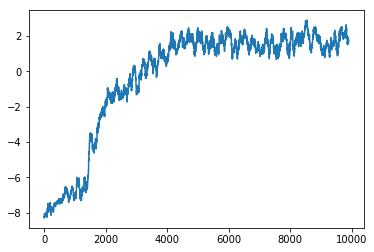

In [169]:
import matplotlib.pyplot as plt
windowed_rewards = np.convolve(rewards, np.ones(100), 'valid')
plt.plot(windowed_rewards/100)
plt.show()